In [17]:
import pandas as pd
import numpy as np

# Simulate timestamps every 5 minutes over 1 day
timestamps = pd.date_range(start='2025-07-14 00:00', end='2025-07-14 23:55', freq='5min')

# Simulate normal heart rate (60–100 bpm)
heart_rate = np.random.normal(loc=75, scale=5, size=len(timestamps))

# Simulate oxygen levels (95–100%)
oxygen_level = np.random.normal(loc=98, scale=1, size=len(timestamps))

# Simulate step count with rest periods and activity spikes
steps = np.random.poisson(lam=5, size=len(timestamps))
steps[(timestamps.hour >= 6) & (timestamps.hour <= 22)] += np.random.poisson(lam=20, size=sum((timestamps.hour >= 6) & (timestamps.hour <= 22)))

# Introduce some anomalies (safe indexes within range)
heart_rate[100] = 150     # very high heart rate
oxygen_level[200] = 85    # low oxygen
steps[250] = 200          # unusual step spike

# Build the DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'heart_rate': np.round(heart_rate),
    'oxygen_level': np.round(oxygen_level),
    'step_count': steps
})

# Preview
df.head()


,timestamp,heart_rate,oxygen_level,step_count
0,2025-07-14 00:00:00,71.0,98.0,4
1,2025-07-14 00:05:00,76.0,96.0,9
2,2025-07-14 00:10:00,85.0,99.0,6
3,2025-07-14 00:15:00,78.0,97.0,6
4,2025-07-14 00:20:00,74.0,98.0,3


In [18]:
# Keep only numerical features
features = df[['heart_rate', 'oxygen_level', 'step_count']]


In [19]:
#Scale the Features (0–1)
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame for readability
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)

# Preview
df_scaled.head()


,heart_rate,oxygen_level,step_count
0,0.141304,0.8125,0.015075
1,0.195652,0.6875,0.040201
2,0.293478,0.8750,0.025126
3,0.217391,0.7500,0.025126
4,0.173913,0.8125,0.010050


In [20]:
# importing and training the model
from sklearn.ensemble import IsolationForest

# Initialize the model
model = IsolationForest(contamination=0.01, random_state=42)  # 1% expected anomalies

# Fit on scaled features
model.fit(df_scaled)

# Predict anomalies
df_scaled['anomaly'] = model.predict(df_scaled)

# Map prediction: -1 = anomaly, 1 = normal
df_scaled['anomaly'] = df_scaled['anomaly'].map({1: 0, -1: 1})

# View how many anomalies were detected
df_scaled['anomaly'].value_counts()


,count
anomaly,
0,285
1,3


In [21]:
# Reattach timestamp column to the scaled data
df_scaled['timestamp'] = df['timestamp']


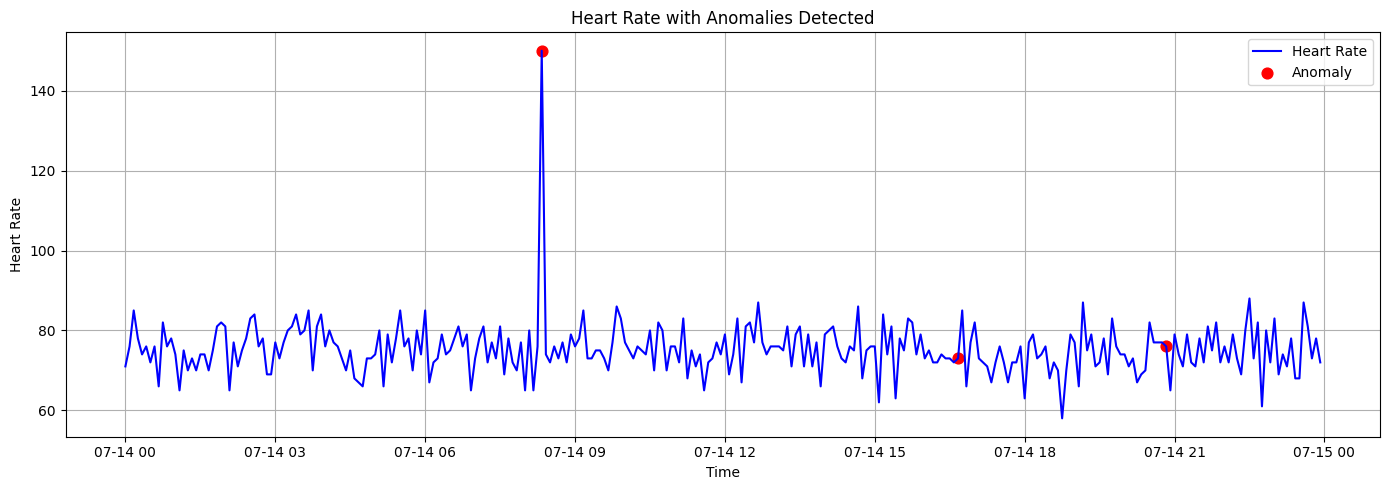

In [22]:
import matplotlib.pyplot as plt

# Convert timestamp to datetime if needed
df_scaled['timestamp'] = pd.to_datetime(df_scaled['timestamp'])

# Plot heart rate over time
plt.figure(figsize=(14, 5))
plt.plot(df_scaled['timestamp'], df['heart_rate'], label='Heart Rate', color='blue')

# Plot anomalies
anomaly_points = df_scaled[df_scaled['anomaly'] == 1]
plt.scatter(anomaly_points['timestamp'], df.loc[anomaly_points.index, 'heart_rate'],
            color='red', label='Anomaly', s=60)

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Heart Rate with Anomalies Detected")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
